In [6]:
import numpy as np
import torch
# torch.multiprocessing.set_start_method('spawn')
from torch import nn
from torch.nn import functional
import kornia
from pathlib import Path

from torch.utils.data import DataLoader, Dataset

from skimage.io import MultiImage

import matplotlib.pyplot as plt
import cv2 as cv
import json

In [2]:
data_dir = Path("../input/prostate-cancer-grade-assessment/train_images/")

In [27]:
def __rgb_to_hsv(image):
    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError("Input size must have a shape of (3, H, W). Got {}".format(image.shape))

    r, g, b = image

    maxc = image.max(-3)[0]
    minc = image.min(-3)[0]

    deltac: torch.Tensor = maxc - minc

    s = deltac / maxc
    s = torch.where(torch.isnan(s), torch.zeros_like(s), s)

    # avoid division by zero
    deltac = torch.where(deltac == 0, torch.ones_like(deltac), deltac)

    maxg = g == maxc
    maxr = r == maxc

    r, g, b = (torch.stack([maxc] * 3) - image) * (1 / deltac)
    del deltac

    h = 4.0 + g - r
    h = torch.where(maxg, 2.0 + r - b, h)
    del maxg, r
    h = torch.where(maxr, b - g, h)
    del maxr, g, b
    h = torch.where(minc == maxc, torch.zeros_like(h), h)
    
    del minc

    h *= 60.0
    h %= 360.0

    return torch.stack([h, s, maxc], dim=-3)

def tile(img, sz=256, N=36, default_val=255):
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    num_channels = 1

    img = torch.from_numpy(img).cuda().half()
    img = 255 - __rgb_to_hsv(img.permute([2, 0, 1]) / 255.0)[1] * 255.0
    img = torch.unsqueeze(img, -1)

    img = functional.pad(img, [0, 0, pad1 // 2, pad1 - pad1 // 2, pad0 // 2, pad0 - pad0 // 2], value=default_val)

    shape = img.shape

    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, num_channels)
    img = img.permute([0, 2, 1, 3, 4]).reshape(-1, sz, sz, num_channels)

    num = len(img)

    if len(img) < N:
        img = functional.pad(img, [0, 0, 0, 0, 0, 0, 0, N - len(img)], value=default_val)

    idxs = torch.argsort(img.reshape(img.shape[0], -1).float().sum(-1))[:N]

    img = img[idxs]
    s = int(np.sqrt(N))
    r = torch.full([sz * s, sz * s, num_channels], default_val, dtype=img.dtype, device='cuda')
    res_boxes = []
    idxs = idxs.detach().cpu().numpy()

    indexes = np.arange(N)

    for i, j in enumerate(indexes):
        if i >= len(img):
            break
        if i >= num:
            break

        x = j % s
        y = j // s
        img_i = img[i]
        r[y * sz:(y + 1) * sz, x * sz:(x + 1) * sz] = img_i

        x = idxs[i] % (shape[1] // sz)
        y = idxs[i] // (shape[1] // sz)
        x1 = x * sz
        x2 = (x + 1) * sz
        y1 = y * sz
        y2 = (y + 1) * sz
        res_boxes.append([x1, y1, x2, y2])

    return r, res_boxes

In [74]:
def tile_hsv_boxes(img, sz=256, N=36, default_val=255):
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    num_channels = 1

    img = cv.cvtColor(img, cv.COLOR_RGB2HSV)[..., 1]
    img = 255 - torch.from_numpy(img).cuda()
    img = torch.unsqueeze(img, -1)

    img = functional.pad(img, [0, 0, pad1 // 2, pad1 - pad1 // 2, pad0 // 2, pad0 - pad0 // 2], value=default_val)

    shape = img.shape

    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, num_channels)
    img = img.permute([0, 2, 1, 3, 4]).reshape(-1, sz, sz, num_channels)

    num = len(img)

    if len(img) < N:
        img = functional.pad(img, [0, 0, 0, 0, 0, 0, 0, N - len(img)], value=default_val)

    idxs = torch.argsort(img.reshape(img.shape[0], -1).float().sum(-1))[:N]

    s = int(np.sqrt(N))
    res_boxes = []
    idxs = idxs.detach().cpu().numpy()

    indexes = np.arange(N)

    for i, j in enumerate(indexes):
        if i >= num:
            break

        x = idxs[i] % (shape[1] // sz)
        y = idxs[i] // (shape[1] // sz)
        x1 = x * sz
        x2 = (x + 1) * sz
        y1 = y * sz
        y2 = (y + 1) * sz
        res_boxes.append([int(x1), int(y1), int(x2), int(y2)])

    return res_boxes

In [75]:
def get_tile(img, boxes, sz=256, num=36):
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    
    img = np.pad(img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]], constant_values=255)
    
    s  = int(np.sqrt(num))
    tile = np.full([sz * s, sz * s, 3], 255, dtype=img.dtype)
    for i, box in enumerate(boxes):
        x = i % s
        y = i // s

        tile[y * sz:(y + 1) * sz, x * sz:(x + 1) * sz] = img[box[1]:box[3], box[0]:box[2]]
    return tile

In [76]:
images = list(data_dir.glob("*.tiff"))

In [77]:
with open("256_36_hsv.json", 'r') as file:
    data = json.load(file)

In [78]:
# tile(img)[1]

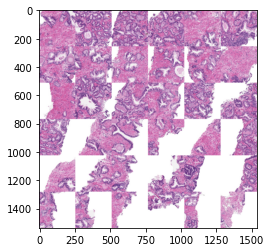

In [85]:
img = MultiImage(str(images[0]))[1]
# plt.imshow(img)
plt.imshow(get_tile(img, result[images[0].name.replace(".tiff", "")]))
# plt.imshow(get_tile(img, tile(img)[1]))
# plt.imshow(get_tile(img, tile_hsv_boxes(img, sz, n)))

In [80]:
idx = 3000
sz = 256
n = 36

# img = MultiImage(str(images[idx]))[1]
# print(img.shape)

# with torch.no_grad():
#     tile_img, tile_boxes = tile(img, sz, n)
#     tile_img = tile_img.cpu().numpy().astype(np.uint8)

# tile2 = get_tile(img, tile_boxes, sz=sz, num=n)

# tmp = img.copy()
# for b in tile_boxes:
#     cv.rectangle(tmp, tuple(b[:2]), tuple(b[2:]), (0, 255, 0), 10)

# plt.figure(figsize=(30, 30))
# plt.subplot(131)
# plt.imshow(tmp)
# plt.subplot(132)
# plt.imshow(np.squeeze(tile_img), cmap='gray' if (tile_img.ndim == 2 or tile_img.shape[-1] == 1) else None)
# plt.subplot(133)
# plt.imshow(tile2)

In [81]:
from tqdm import tqdm

In [82]:
result = {}

for path in tqdm(images):
    img = MultiImage(str(path))[1]
    path = path.name.replace(".tiff", "")
    box = tile_hsv_boxes(img, sz, n)
    result[path] = box

100%|██████████| 10616/10616 [22:08<00:00,  7.99it/s]


In [86]:
with open('256_36_hsv.json', 'w') as file:
    json.dump(result, file)

In [30]:
len(result)

10616

In [31]:
import json

In [36]:
result['2f305c85a7bb5ce4ea89ceee84f17f6b']

[[4608, 6912, 4864, 7168],
 [4352, 6912, 4608, 7168],
 [3840, 6912, 4096, 7168],
 [4096, 6912, 4352, 7168],
 [3072, 6912, 3328, 7168],
 [2816, 6912, 3072, 7168],
 [3328, 6912, 3584, 7168],
 [3584, 6912, 3840, 7168],
 [1536, 6912, 1792, 7168],
 [1280, 6912, 1536, 7168],
 [768, 6912, 1024, 7168],
 [1024, 6912, 1280, 7168],
 [2048, 6912, 2304, 7168],
 [1792, 6912, 2048, 7168],
 [2304, 6912, 2560, 7168],
 [2560, 6912, 2816, 7168],
 [4352, 6656, 4608, 6912],
 [4096, 6656, 4352, 6912],
 [3584, 6656, 3840, 6912],
 [3840, 6656, 4096, 6912],
 [2816, 6656, 3072, 6912],
 [2560, 6656, 2816, 6912],
 [3072, 6656, 3328, 6912],
 [3328, 6656, 3584, 6912],
 [5376, 6656, 5632, 6912],
 [5120, 6656, 5376, 6912],
 [4608, 6656, 4864, 6912],
 [4864, 6656, 5120, 6912],
 [256, 6912, 512, 7168],
 [512, 6912, 768, 7168],
 [2048, 6656, 2304, 6912],
 [2304, 6656, 2560, 6912],
 [4096, 6400, 4352, 6656],
 [3840, 6400, 4096, 6656],
 [3328, 6400, 3584, 6656],
 [3584, 6400, 3840, 6656]]

In [47]:
for path in list(result.keys()):
    box = result[path]
    nbox = []
    for b in box:
        nbox.append([int(i) for i in b])
    result[path] = nbox

In [48]:
type([int(i) for i in box[0]][0])

int

In [49]:
type(box[0][0])

numpy.int64

In [50]:
with open('256_36_hsv.json', 'w') as file:
    json.dump(result, file)

In [11]:
result = {}
for path, box in zip(resul_paths, result_boxes):
    path = os.path.slit(path)[1].replace(".tiff", "")
    result[path] = box

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/dipet/main_venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-9a89480ade12>", line 2, in <module>
    for path, box in zip(resul_paths, result_boxes):
NameError: name 'resul_paths' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/dipet/main_venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/dipet/main_venv/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File 

NameError: name 'resul_paths' is not defined

In [12]:
result_paths

['../input/prostate-cancer-grade-assessment/train_images/2f305c85a7bb5ce4ea89ceee84f17f6b.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/5d3dfae104348251b8fbc99f8d39a601.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/89f418346fc412a6458aaa05a224af3a.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/b53d843700d9665439ec8791e4024d70.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/0005f7aaab2800f6170c399693a96917.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/000920ad0b612851f8e01bcc880d9b3d.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/0018ae58b01bdadc8e347995b69f99aa.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/001c62abd11fa4b57bf7a6c603a11bb9.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/001d865e65ef5d2579c190a0e0350d8f.tiff',
 '../input/prostate-cancer-grade-assessment/train_images/002a4db09dad406c85505a00fb6f6144.tiff',
 '../input/prostate-cancer-gra